In [1]:
#Imports
import sys
sys.path.append('../python/')
import NGC5533_functions_diskparam as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

In [2]:
data = dp.getXYdata_wXYerr('data/NGC5533-rot-data_fmt.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

In [3]:
def f(r,M,rc,rho00,c,n,re,h,d_rho00,pref):
#def f(r,M,rc,rho00,c):
    return np.sqrt(nf.bh_v(r,M,load=True)**2 + nf.h_v(r,rc,rho00,load=True)**2 + c*nf.b_v(r,n,re,load=True)**2 + nf.d_v(r,h,d_rho00,pref,load=True)**2)

In [4]:
#Setup
weighdata = 1/v_err1
l_mod = lm.Model(f)
params = l_mod.make_params()
#Black Hole
params.add('M', value=nf.Mbh_def, min=0) #Mass
#Bulge
params.add('c', value=1, min=0)          #Contributions should all add
params.add('n', value=nf.n_c, min=0) 
params.add('re', value=nf.re_c, min=0) 
#Disk
params.add('h', value=nf.h_c, min=0)
params.add('d_rho00', value=nf.drho00_c, min=0)
params.add('pref', value=0.5, min=0)
#Halo
params.add('rc', value=nf.h_rc, min=0)   #Radius (magnitude)
params.add('rho00', value=nf.hrho00_c, min=0) #Density (halo)

#Do fit
l_fit = l_mod.fit(v_dat,params,r=r_dat,weights=weighdata)

#Define Stuff
l_dict = l_fit.best_values
l_M = l_dict['M']
l_rc = l_dict['rc']
l_hrho00 = l_dict['rho00']
l_h = l_dict['h']
l_drho00 = l_dict['d_rho00']
l_pref = l_dict['pref']
l_c = l_dict['c']
l_n = l_dict['n']
l_re = l_dict['re']

l_curve = np.sqrt(nf.bh_v(r_dat,l_M,load=True)**2 + nf.h_v(r_dat,l_rc,l_hrho00,load=True)**2 + l_c*nf.b_v(r_dat,l_n,l_re,load=True)[1]**2 + nf.d_v(r_dat,l_h,l_drho00,l_pref,load=True)**2)
    
b_curve = l_c*nf.b_v(r_dat,l_n,l_re,load=True)
d_curve = nf.d_v(r_dat,l_h,l_drho00,l_pref,load=True) #Disk only
bh_curve = nf.bh_v(r_dat,l_M,load=True)
h_curve = nf.h_v(r_dat,l_rc,l_hrho00,load=True)
nodisk = np.sqrt(nf.bh_v(r_dat,l_M,load=True)**2 + nf.h_v(r_dat,l_rc,l_hrho00,load=True)**2 + l_c*nf.b_v(r_dat,l_n,l_re,load=True)**2)

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


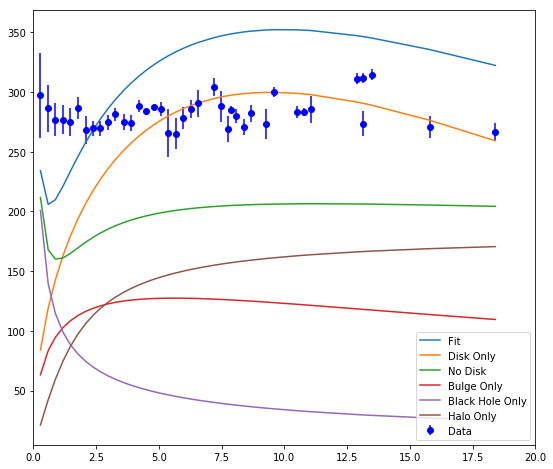

In [5]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,20)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,label='Fit')
plt.plot(r_dat,d_curve,label='Disk Only')
plt.plot(r_dat,nodisk,label='No Disk')
plt.plot(r_dat,b_curve,label='Bulge Only')
plt.plot(r_dat,bh_curve,label='Black Hole Only')
plt.plot(r_dat,h_curve,label='Halo Only')

plt.legend()
plt.show()

l_fit

In [6]:
#nf.d_v(r_dat,pref=0.5000000124176345,save=True)

In [7]:
# Using fitted parameters to calculate parameters for Galactic Components
    
# Bulge
print('Bulge')
print('Scaling constant,         C = {:.2f}'.format(l_c))
print('Concentration parameter,  n = {:.2f}'.format(l_n))
print('Effective radius,         re = {:.2f} [kpc]'.format(l_re))

upsbulge = l_c * nf.b_r0(l_n,l_re) * l_n / (4 * nf.G * nf.q * nf.b_I0(l_n,l_re) * (np.sqrt((np.sin(nf.i)**2)+(1/(nf.q**2))*(np.cos(nf.i)**2))))
print('Mass-to-Light Ratio,      upsdisk = {:.5e}'.format(upsbulge))

# comparing to fixed consants of re and n:
#ups2bulge = l_c * nf.b_r0(nf.n_c,nf.re_c) * nf.n_c / (4 * nf.G * nf.q * nf.b_I0(nf.n_c,nf.re_c) * (np.sqrt((np.sin(nf.i)**2)+(1/(nf.q**2))*(np.cos(nf.i)**2))))
#print('Mass-to-Light Ratio,      ups = {:.5e}'.format(ups2bulge))

#print(l_n)
#print(nf.n_c)
#print(l_re)
#print(nf.re_c)

print('')


# Disk
print('Disk')
print('Radial Scale Length,      h = {:.3f} [kpc]'.format(l_h))
print('Central Surface Density,  rho00 = {:.3e} [solar mass/kpc^3]'.format(l_drho00))
print('Scaling constant,         prefactor = {:.3f}'.format(l_pref))

r = (0.1, 125, 100)
upsdisk = l_pref * nf.d_Mdblintrho(r,nf.h_c,nf.drho00_c) / nf.L0
print('Mass-to-Light Ratio,      upsdisk = {:.5e}'.format(upsdisk))
print(nf.d_Mdblintrho(r,nf.h_c,nf.drho00_c))

print('')


# Black Hole
print('Black Hole')
print('Mass of the Black Hole,   M(bh) = {:.3e} [solar masses]'.format(l_M))
print('')


# Dark Halo
print('Dark Halo')
print('Halo central density,     rho00 = {:.3e} [solar mass/kpc^3]'.format(l_hrho00))
print('Core radius,              rc = {:.2f} [kpc]'.format(l_rc))


# Gas

Bulge
Scaling constant,         C = 1.00
Concentration parameter,  n = 2.70
Effective radius,         re = 9.90 [kpc]
Mass-to-Light Ratio,      upsdisk = 9.20607e-06

Disk
Radial Scale Length,      h = 8.900 [kpc]
Central Surface Density,  rho00 = 3.100e+08 [solar mass/kpc^3]
Scaling constant,         prefactor = 0.500
Mass-to-Light Ratio,      upsdisk = -1.79706e+07
-1.3539167495244508e+18

Black Hole
Mass of the Black Hole,   M(bh) = 2.700e+09 [solar masses]

Dark Halo
Halo central density,     rho00 = 3.100e+08 [solar mass/kpc^3]
Core radius,              rc = 1.40 [kpc]
